## Toy Tomography

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import RectBivariateSpline
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, rotate

## Analytical Reconstruction for now

For some 2D object described by it's attentuation coefficient $f(x,y)$, we know that the the intensity of a single pixel $I$ is related to the source intensity $I_0$ where
$$ I = I_0e^{-\int f(x,y)ds} $$ 
where $ds$ is the straigt line traveled by light from $I_0$ to $I$. Additionally the parameters $\theta$, $r$, and $t$ specify the in-plane rotation of the object in radians, and position along the 1D detector, and the in-plane translation.

So we want to reconstruct $f(x,y)$ given $p(\theta, r, t)$.

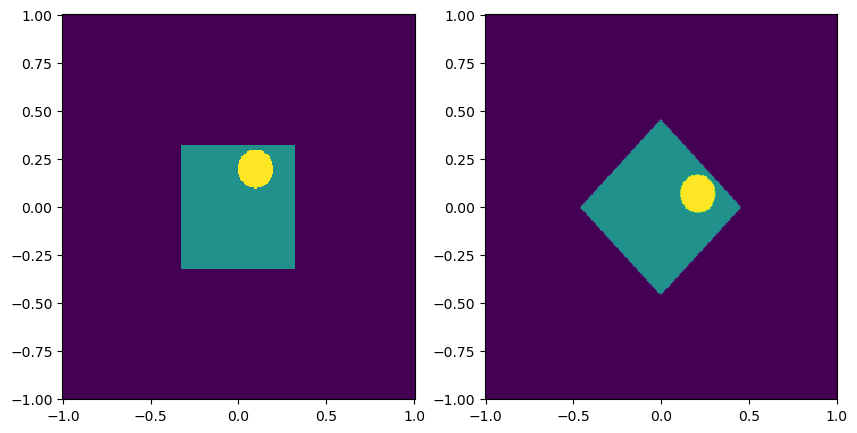

In [2]:
image_0 = np.ones([100,100]) #create a square
# Resize Image
diag_0 = len(np.diag(image_0)//2)
image_0 = np.pad(image_0, pad_width=diag_0+5)

_ = np.linspace(-1, 1, image_0.shape[0])
xv, yv = np.meshgrid(_,_)
image_0[(xv-0.1)**2+(yv-0.2)**2<0.01] = 2 #make the circle =2
x_mov = -20
y_mov = -40
#image_0[(xv- (x_mov/155) - 0.1)**2+(yv - y_mov/155 -0.2)**2<0.01] = 4 #make the circle =2


# Create a rotated image
image_rot_0 = rotate(image_0, 45)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].pcolor(xv,yv,image_0, shading='auto')
ax[1].pcolor(xv,yv,image_rot_0, shading='auto')
plt.show()

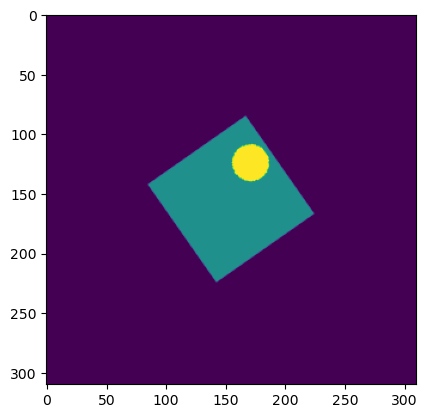

In [20]:
thetas = np.arange(0,180,5) * np.pi/180
rs = _
dtheta = np.diff(thetas)[0]
dr = np.diff(rs)[0]
rotations = np.array([rotate(image_0, theta*180/np.pi) for theta in thetas])
plt.imshow(rotations[25])

In [4]:
#the sinogram
p = np.array([rotation.sum(axis=0)*dr for rotation in rotations]).T

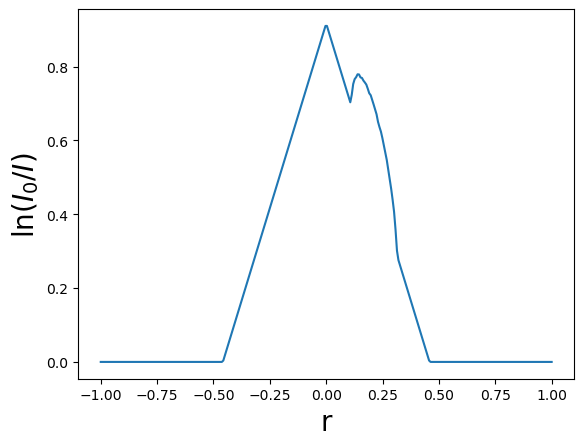

In [5]:
#plot the scan at a given angle, this is the RADON transrom
plt.plot(rs, p[:,9])
plt.xlabel('r', fontsize=20)
plt.ylabel('$\ln(I_0/I)$', fontsize=20)
plt.show()

## Fourier Transform of the Radon Transform above

torch.Size([310])


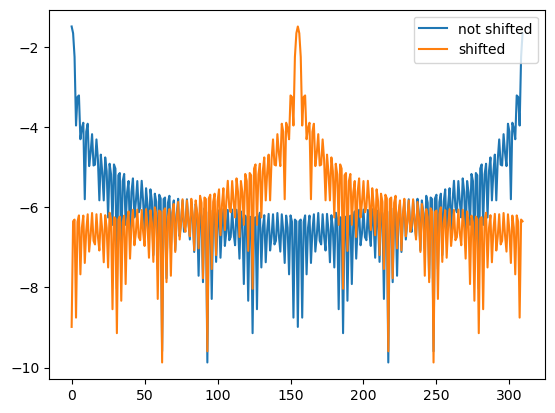

In [43]:
import torch
slice = torch.fft.fft(torch.tensor(p[:,0]), norm = "forward")
plt.plot(np.arange(len(slice)), torch.log(torch.abs(slice)), label = 'not shifted')

shift_slice = torch.fft.fftshift(slice)
plt.plot(np.arange(len(slice)), torch.log(torch.abs(shift_slice)), label = 'shifted')
plt.legend()
fft_of_radon = torch.log(torch.abs(shift_slice))
print(fft_of_radon.shape)

# Fourier Slice theorem

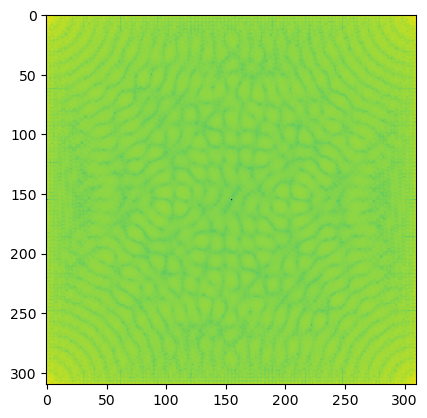

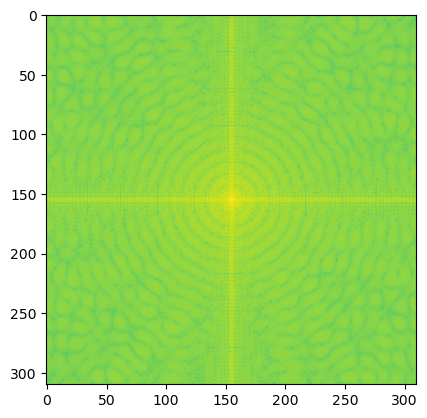

tensor(19.7319, dtype=torch.float64)


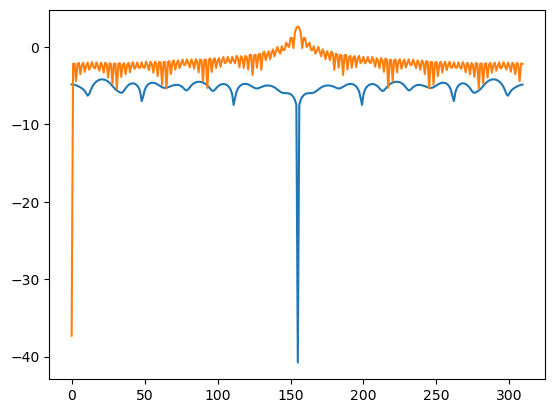

In [53]:
twod_fft = torch.fft.fft2(torch.tensor(image_0)*(255/ torch.max(torch.tensor(image_0)[:,:])), norm = "forward")
plt.imshow(torch.log(torch.abs(twod_fft)))
plt.show()
plt.imshow(torch.log(torch.abs(torch.fft.fftshift(twod_fft))))
plt.show()
plt.plot(np.arange(torch.abs(twod_fft)[:,155].shape[0]), torch.log(torch.abs(twod_fft)[:,155]))
plt.plot(np.arange(torch.abs(twod_fft)[:,155].shape[0]), torch.log(torch.abs(torch.fft.fftshift(twod_fft))[:,155]))
slice_of_2dfft = torch.log(torch.abs(torch.fft.fftshift(twod_fft))[:,155])
print(torch.sum(torch.pow(slice_of_2dfft - fft_of_radon, 2))/ slice_of_2dfft.shape[0])

## Sinogram

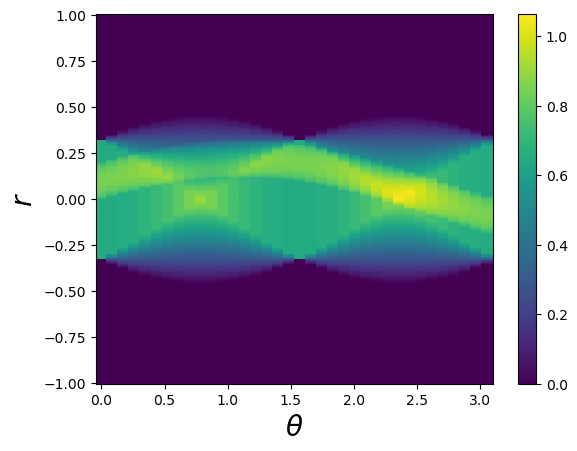

In [8]:
plt.pcolor(thetas, rs, p, shading='auto')
plt.xlabel(r'$\theta$', fontsize=20)
plt.ylabel('$r$', fontsize=20)
plt.colorbar()
plt.show()

## Regular Back Projection

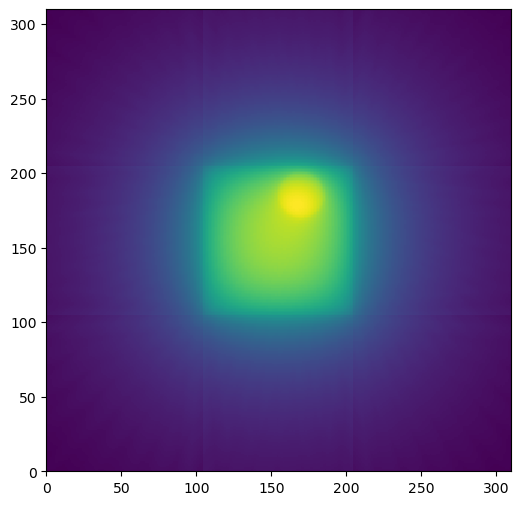

In [9]:
p_interp = RectBivariateSpline(rs, thetas, p)
def get_fBP(x,y):
    return p_interp(x*np.cos(thetas)+y*np.sin(thetas), thetas, grid=False).sum() * dtheta

fBP = np.vectorize(get_fBP)(xv,yv)
plt.figure(figsize=(6,6))
plt.pcolor(fBP)
plt.show()

# Attempt at translation

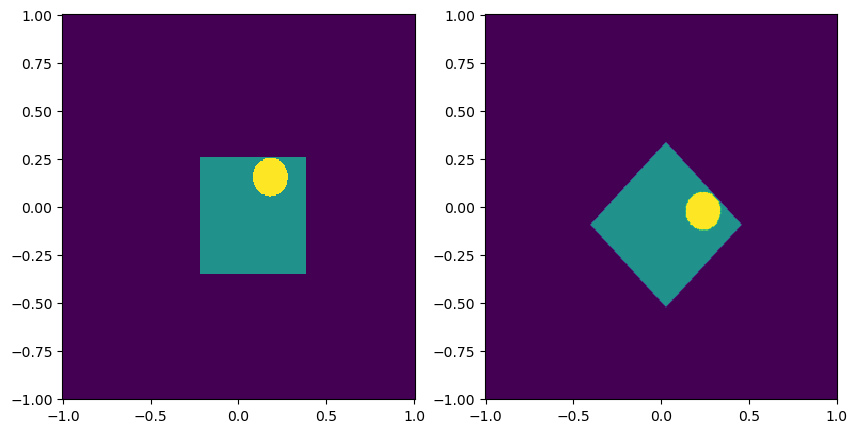

In [10]:
#translate
image = np.ones([100,100]) #create a square
# Resize Image
diag = len(np.diag(image)//2)
translation_max = 30
rand_int_1 = np.random.randint(0, translation_max)
rand_int_2 = np.random.randint(0, translation_max)

image = np.pad(image, pad_width=((diag + rand_int_1, diag + (translation_max-rand_int_1)), (diag + rand_int_2, diag + (translation_max-rand_int_2))))
_ = np.linspace(-1, 1, image.shape[0])
xv, yv = np.meshgrid(_,_)
image[(xv + (((translation_max/2)-rand_int_2)/(image.shape[0]/2)) -0.1)**2 + (yv + ((((translation_max/2)-rand_int_1))/(image.shape[0]/2))-0.2)**2<0.01] = 2
image_rot = rotate(image, 45)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].pcolor(xv,yv,image, shading='auto')
ax[1].pcolor(xv,yv,image_rot, shading='auto')
plt.show()


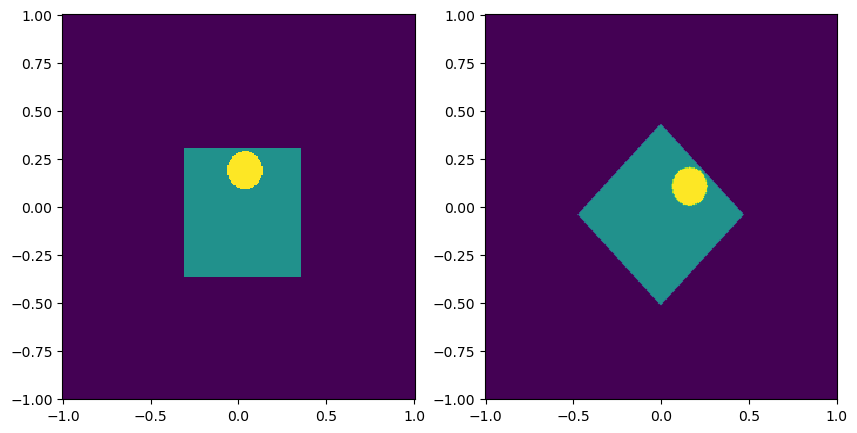

In [11]:
#translate
image = np.zeros([300,300]) #create a square
# Resize Image
diag = len(np.diag(image)//2)
translation_max = 10
rand_int_1 = np.random.randint(-translation_max, translation_max)
rand_int_2 = np.random.randint(-translation_max, translation_max)
image[100 + rand_int_1 : 200+ rand_int_1, 100 + rand_int_2 : 200 + rand_int_2] = 1
#image = np.pad(image, pad_width=((diag + rand_int_1, diag + (translation_max-rand_int_1)), (diag + rand_int_2, diag + (translation_max-rand_int_2))))
_ = np.linspace(-1, 1, image.shape[0])
xv, yv = np.meshgrid(_,_)
image[(xv + (((translation_max/2)-rand_int_1)/(image.shape[0]/2)) -0.1)**2 + (yv + ((((translation_max/2)-rand_int_2))/(image.shape[0]/2))-0.2)**2<0.01] = 2
image_rot = rotate(image, 45)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].pcolor(xv,yv,image, shading='auto')
ax[1].pcolor(xv,yv,image_rot, shading='auto')
plt.show()


## Slice Theorem

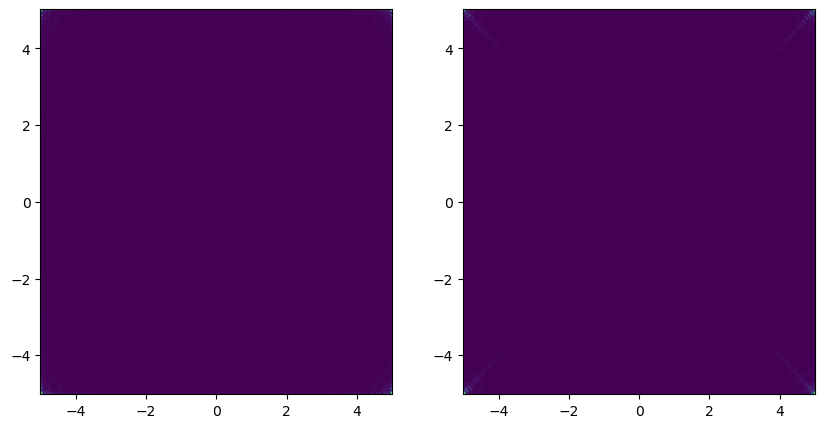

In [12]:
import torch
f_image = torch.fft.fft2(torch.tensor(image), norm = "forward")
f_image_rot = torch.fft.fft2(torch.tensor(image_rot), norm = "forward")
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].pcolor(5*xv,5*yv,torch.abs(f_image), shading='auto')
ax[1].pcolor(5*xv,5*yv,torch.abs(f_image_rot), shading='auto')
plt.show()

In [13]:
from skimage.data import astronaut

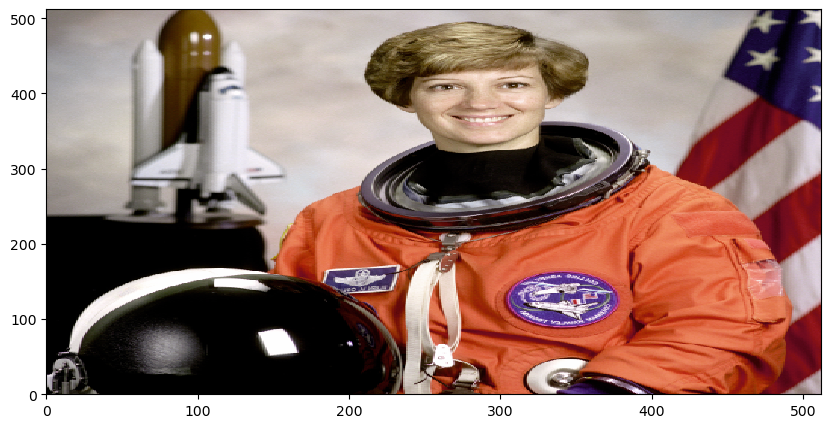

In [14]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.pcolor(rotate(astronaut(), 180))
plt.show()

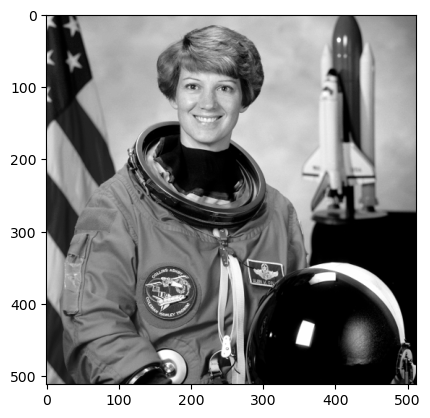

(512, 512)


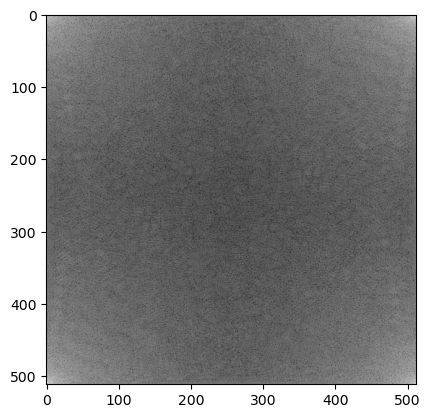

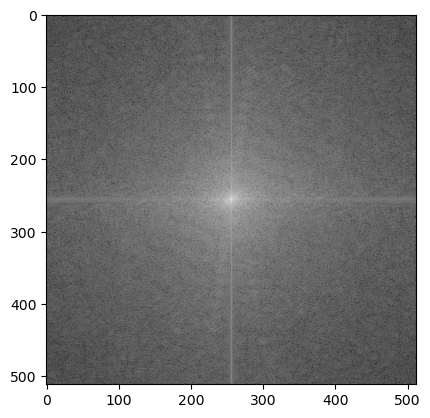

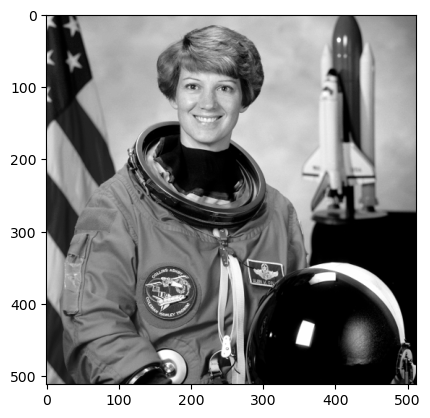

In [48]:
#new_image = rotate(astronaut(), 180)
new_image = astronaut()
#print(np.shape(new_image))
#avg = np.zeros_like(new_image[:,:,0])
#for i in range(3):
#    avg+= new_image[:,:,i]
#avg/ (255*3)
from skimage import color

new_image = color.rgb2gray(new_image)

plt.imshow(new_image, cmap = 'gray')
plt.show()

print(np.shape(new_image))
new_image = torch.tensor(new_image)

f_image_new = torch.fft.fft2(new_image,norm = "forward")
plt.imshow(torch.log(torch.abs(f_image_new)), cmap = 'gray')
plt.show()

shift = torch.fft.fftshift(f_image_new)
plt.imshow(torch.log(torch.abs(shift)), cmap = 'gray')
plt.show()

inverse = torch.fft.ifftshift(shift)
recover = torch.fft.ifft2(inverse)
plt.imshow(torch.abs(recover), cmap = 'gray')
plt.show()



In [16]:
print(torch.min(torch.abs(f_image_new[:,:])))

tensor(1.4945e-07, dtype=torch.float64)
